# Model Selection:

## Goal:

Find the model that appears to provide best validation results.

### Validation Metrics:


## Some questions we're trying to answer:
1. How complex does the model need to be? ie; how many parameters?
2. How big does the latent representation need to be? (ie; deep vs shallow netwoorks)
3. How sensitive is the model to hyperparameter tuning?
4. What hyperparameters are we finally choosing in the end and why?
5. Is the validation loss a good metric compared to cluster comparison?


## Chosen Models:

All models have between 27,000 and 29,000 parameters, roughly equally complex.

- **Model A** is 3 layers deep with latent representation dimensions: [12,27,12]
- **Model B** is 2 layers deep with latent representation dimensions: [24,54,14]
- **Model C** is 2 layers deep with latent representation dimensions: [4,9,5]

## Load Training and Validation data:

In [1]:
import tensorflow as tf
import numpy as np
from numpy import save
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle
from IPython.display import Image

In [2]:
tf.keras.backend.clear_session()

# gpu = tf.config.experimental.list_physical_devices('GPU')[0]
# tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
X_train = np.load('/datasets/home/21/321/ee228sp20ta1/G51/train_set.npy')
X_valid = np.load('/datasets/home/21/321/ee228sp20ta1/G51/val_set.npy')

## Scale and Reshape data

In [4]:
# x_train = X_train[:,:,:216].copy()
X_train = X_train.reshape((X_train.shape[0]*96,216))

# x_valid = X_valid[:,:,:216].copy()
X_valid = X_valid.reshape((X_valid.shape[0]*96,216))


# print(x_train.shape)
# print(x_valid.shape)

scaler = MinMaxScaler().fit(X_train) 
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

s_train_reshaped = X_train.reshape(-1,96,216,1)
s_valid_reshaped = X_valid.reshape(-1,96,216,1)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((s_train_reshaped[:10800,:,:,:], s_train_reshaped[:10800,:,:,:]))
valid_dataset = tf.data.Dataset.from_tensor_slices((s_valid_reshaped, s_valid_reshaped))

batch_size = 5
shuffle_buffer_size = 100


train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

In [6]:
del X_train, X_valid

## Models:

In [2]:
def ModelA():
    
    #### Encoder ####
    model = models.Sequential()
    model.add(keras.Input(shape=(96,216,1)))
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(12, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #### Decoder ####
    model.add(layers.Conv2D(12, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(1,(3, 3), padding='same'))
    
    return model

In [7]:
def ModelB():
    
    #### Encoder ####
    model = models.Sequential()
    model.add(keras.Input(shape=(96,216,1)))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(14, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #### Decoder ####
    model.add(layers.Conv2D(14, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(1,(3, 3), padding='same'))
    
    return model

In [30]:
def ModelC():
    
    #### Encoder ####
    model = models.Sequential()
    model.add(keras.Input(shape=(96,216,1)))
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(12, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(5, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((3, 3)))
    
    #### Decoder ####
    model.add(layers.Conv2D(5, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(3,3)))
    model.add(layers.Conv2D(12, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(1,(3, 3), padding='same'))
    
    return model

## Model A training

In [13]:
AE  = ModelA()
# print(AE.summary())

In [14]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
AE.compile(loss='mse', optimizer=opt)
history_modelA = AE.fit(train_dataset, validation_data= valid_dataset, epochs=125)


Train for 2160 steps, validate for 553 steps
Epoch 1/125
2160/2160 [==============================] - 21s 10ms/step - loss: 0.0069 - val_loss: 0.0045
Epoch 2/125
2160/2160 [==============================] - 20s 9ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 3/125
2160/2160 [==============================] - 20s 9ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 4/125
2160/2160 [==============================] - 20s 9ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 5/125
2160/2160 [==============================] - 20s 9ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/125
2160/2160 [==============================] - 20s 9ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/125
2160/2160 [==============================] - 20s 9ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/125
2160/2160 [==============================] - 21s 10ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/125
2160/2160 [==============================] - 21s 10ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/125
216

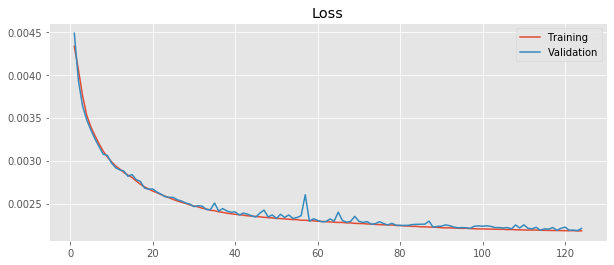

<Figure size 432x288 with 0 Axes>

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(10,4))

plt.plot(range(len(history_modelA.history['loss']))[1:], history_modelA.history['loss'][1:], label='Training')
plt.plot(range(len(history_modelA.history['loss']))[1:], history_modelA.history['val_loss'][1:], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()
plt.savefig('ModelA2_125epoch.png')

In [16]:
import os
cwd = os.getcwd()
AE.save_weights(cwd+'/ExpTestModels228/ModelA2/modelA2')

import pickle 
with open(cwd + '/ExpTestModels228/pickles/modelA2.pickle', 'wb') as handle:
    pickle.dump(history_modelA.history, handle)


## Model 1 with all relu layers, batchsize 5 and mse loss, 30 epochs, 10,800 samples
## Model 2 with inner sigmoid layers, batchsize 5 and mse loss, 40 epochs, 10,800 samples
## Model 3 with 2 inner sigmoid layers, batchsize 5 and mse loss, 40 epochs, 10,800 samples
## Model 4 with all relu layers, batchsize 15 and mse loss, 50 epochs, 10,800 samples, dataset object
## Model 5 with all relu layers, batchsize 10 and mse loss, 50 epochs, 10,800 samples, dataset object
## Model 6 with all relu layers, batchsize 5 and mse loss, 50 epochs, 10,800 samples, dataset object

#lr = 0.01
## Model 7 with all relu layers, batchsize 5 and mse loss, 50 epochs, 10,800 samples, dataset object
## Model 8 with all relu layers, batchsize 10 and mse loss, 50 epochs, 10,800 samples, dataset object

#lr = 0.0005
## Model 9 with all relu layers, batchsize 15 and mse loss, 50 epochs, 10,800 samples, dataset object
## Model 10 with all relu layers, batchsize 10 and mse loss, 50 epochs, 10,800 samples, dataset object
## Model 11 with all relu layers, batchsize 5 and mse loss, 50 epochs, 10,800 samples, dataset object


In [4]:
import os
cwd = os.getcwd()
AE = AE_02_A()
AE.load_weights(cwd+'/ExpTestModels228/ModelA2/modelA2')

## Model B Training

In [8]:
AE = ModelB()

opt = keras.optimizers.Adam(learning_rate=0.0005)
AE.compile(loss='mse', optimizer=opt)
history_modelB = AE.fit(train_dataset, validation_data= valid_dataset, epochs=125)


Train for 2160 steps, validate for 553 steps
Epoch 1/125
2160/2160 [==============================] - 32s 15ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 2/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/125
2160/2160 [==============================] - 28s 13ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/125
2160/2160 [==============================] - 29s 13ms/step - loss: 9.8777e-04 - val_loss: 0.0011
Epoch 9/125
2160/2160 [==============================] - 29s 13ms/step - loss: 9.5885e-04 - val_loss: 9.3151e-0

2160/2160 [==============================] - 28s 13ms/step - loss: 6.5640e-04 - val_loss: 6.4761e-04
Epoch 74/125
2160/2160 [==============================] - 28s 13ms/step - loss: 6.5582e-04 - val_loss: 6.7223e-04
Epoch 75/125
2160/2160 [==============================] - 28s 13ms/step - loss: 6.5425e-04 - val_loss: 6.5518e-04
Epoch 76/125
2160/2160 [==============================] - 28s 13ms/step - loss: 6.5373e-04 - val_loss: 6.4476e-04
Epoch 77/125
2160/2160 [==============================] - 28s 13ms/step - loss: 6.5252e-04 - val_loss: 6.4952e-04
Epoch 78/125
2160/2160 [==============================] - 28s 13ms/step - loss: 6.5157e-04 - val_loss: 6.4765e-04
Epoch 79/125
2160/2160 [==============================] - 29s 13ms/step - loss: 6.5127e-04 - val_loss: 6.4773e-04
Epoch 80/125
2160/2160 [==============================] - 28s 13ms/step - loss: 6.4946e-04 - val_loss: 6.4277e-04
Epoch 81/125
2160/2160 [==============================] - 28s 13ms/step - loss: 6.4914e-04 - val_loss

FileNotFoundError: [Errno 2] No such file or directory: '/home/adantulu/ExpModels228/pickles/modelB1.pickle'

In [9]:
import os
cwd = os.getcwd()
AE.save_weights(cwd+'/ExpTestModels228/ModelB1/modelB1')

import pickle 
with open(cwd + '/ExpTestModels228/pickles/modelB1.pickle', 'wb') as handle:
    pickle.dump(history_modelB.history, handle)


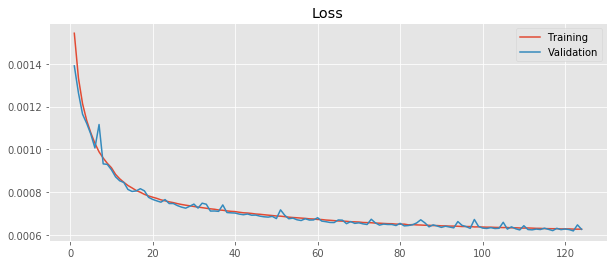

<Figure size 432x288 with 0 Axes>

In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(10,4))

plt.plot(range(len(history_modelB.history['loss']))[1:], history_modelB.history['loss'][1:], label='Training')
plt.plot(range(len(history_modelB.history['loss']))[1:], history_modelB.history['val_loss'][1:], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()
plt.savefig('ModelB1_125epochs.png')

In [ ]:
#lr = 0.001
##Model 1 with all relu layers, batchsize 5 and mse loss, 50 epochs, 10,800 samples, dataset object
##Model 2 with all relu layers, batchsize 10 and mse loss, 50 epochs, 10,800 samples, dataset object
##Model 3 with all relu layers, batchsize 15 and mse loss, 50 epochs, 10,800 samples, dataset object
#lr = 0.0005
##Model 4 with all relu layers, batchsize 15 and mse loss, 50 epochs, 10,800 samples, dataset object
##Model 5 with all relu layers, batchsize 5 and mse loss, 50 epochs, 10,800 samples, dataset object
##Model 6 with all relu layers, batchsize 10 and mse loss, 50 epochs, 10,800 samples, dataset object


## Model B Latent representations

In [25]:
AETest = ModelB()
AETest.load_weights(cwd+'/ExpTestModels228/ModelB1/modelB1')

print(AETest.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 96, 216, 96)       960       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 108, 96)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 48, 108, 14)       12110     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 54, 14)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 54, 14)        1778      
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 48, 108, 14)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 48, 108, 96)      

In [27]:
decoded_data = AETest.predict(s_valid_reshaped)
mini_batch = s_valid_reshaped[:100]
#print(mini_batch.shape)
get_hl = K.function([AETest.layers[0].input], [AETest.layers[4].output])
AE_h1 = get_hl(mini_batch)[0]

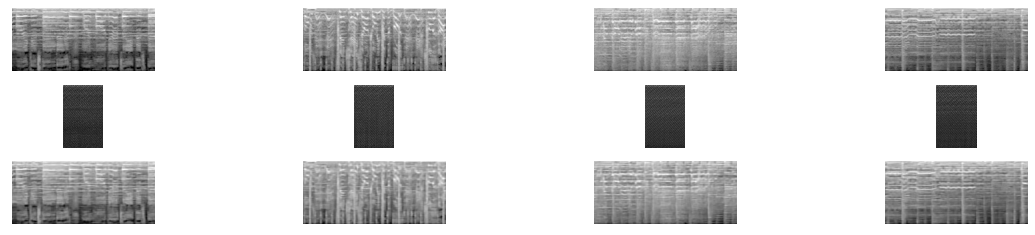

In [28]:
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(s_valid_reshaped[i].reshape(96, 216))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(AE_h1[i].reshape(168, 108)) # Will have to reshape if you change the latent dimensionality
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_data[i].reshape(96, 216))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Model C training

In [31]:
AE = ModelC()
print(AE.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 96, 216, 48)       480       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 48, 108, 48)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 48, 108, 24)       10392     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 24, 54, 24)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 24, 54, 12)        2604      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 12, 27, 12)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 12, 27, 5)       

In [32]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
AE.compile(loss='mse', optimizer=opt)
history_modelA = AE.fit(train_dataset, validation_data= valid_dataset, epochs=125)


Train for 2160 steps, validate for 553 steps
Epoch 1/125
2160/2160 [==============================] - 38s 18ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 2/125
2160/2160 [==============================] - 34s 16ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 3/125
2160/2160 [==============================] - 34s 16ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 4/125
2160/2160 [==============================] - 34s 16ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/125
2160/2160 [==============================] - 34s 16ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 6/125
2160/2160 [==============================] - 32s 15ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/125
2160/2160 [==============================] - 32s 15ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 8/125
2160/2160 [==============================] - 31s 14ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 9/125
2160/2160 [==============================] - 31s 14ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 10/1

Epoch 78/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 79/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 80/125
2160/2160 [==============================] - 29s 14ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 81/125
2160/2160 [==============================] - 29s 14ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 82/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 83/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 84/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 85/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 86/125
2160/2160 [==============================] - 29s 13ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 87/125
2160/2160 [======================

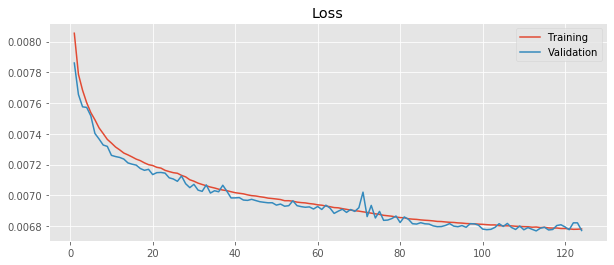

<Figure size 432x288 with 0 Axes>

In [33]:
plt.style.use('ggplot')
plt.figure(figsize=(10,4))

plt.plot(range(len(history_modelA.history['loss']))[1:], history_modelA.history['loss'][1:], label='Training')
plt.plot(range(len(history_modelA.history['loss']))[1:], history_modelA.history['val_loss'][1:], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()
plt.savefig('ModelC_125epoch.png')

In [35]:
import os
cwd = os.getcwd()
AE.save_weights(cwd+'/ExpTestModels228/ModelC/modelC')

import pickle 
with open(cwd + '/ExpTestModels228/pickles/modelC.pickle', 'wb') as handle:
    pickle.dump(history_modelA.history, handle)


## Model C Latent Representations

In [37]:
decoded_data = AE.predict(s_valid_reshaped)
mini_batch = s_valid_reshaped[:100]
#print(mini_batch.shape)
get_hl = K.function([AE.layers[0].input], [AE.layers[8].output])
AE_h1 = get_hl(mini_batch)[0]

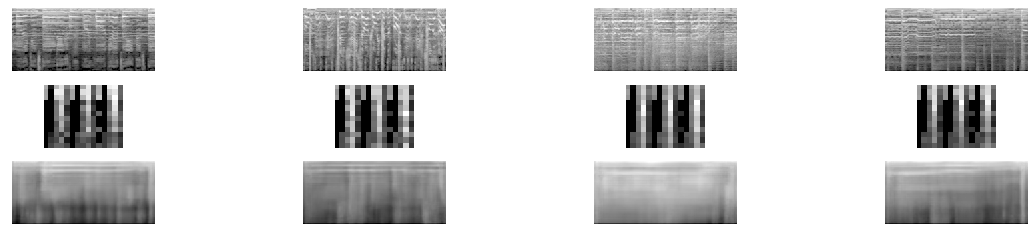

In [38]:
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(s_valid_reshaped[i].reshape(96, 216))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(AE_h1[i].reshape(12, 15)) # Will have to reshape if you change the latent dimensionality
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_data[i].reshape(96, 216))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()